In [14]:
import random
import pandas as pd
import numpy as np
from datetime import datetime

current_year = 2025

# Define value ranges
employment_statuses = ['employed', 'unemployed']
categories = ['daily', 'weekly', 'monthly']
repayment_ratings = ['Excellent', 'Better', 'Good', 'Bad', 'Poor']
ages = list(np.random.randint(1, 100, size=50))  # 100 random ages between 1 and 80

total_saving_min = 1
total_saving_max = 10_000_000
guardian_options = [True, False]
saving_status_options = ['Excellent', 'Better', 'Good', 'Bad', 'Poor']

def get_total_saving_times(category, times_per_period):
    if category == 'daily':
        return times_per_period * 365
    elif category == 'weekly':
        return times_per_period * 52
    elif category == 'monthly':
        return times_per_period * 12

def get_age_factor(age):
    if age <= 10:
        return 0.10
    elif age <= 15:
        return 0.30
    elif age <= 18:
        return 0.40
    elif age <= 50:
        return 1.00
    elif age <= 70:
        return 0.70
    else:
        return 0.0

def get_repayment_factor(rating):
    return {
        'Excellent': 1.0,
        'Better': 0.8,
        'Good': 0.6,
        'Bad': 0.4,
        'Poor': 0.2
    }[rating]

def calculate_loan_features(row):
    if row['TotalCurrentSaving'] <= 0 or row['UserSavingsMade'] <= 0 or row['CompletedSavingCycles'] <= 0:
        return {
            'SavingStatus': 'Poor',
            'SavingRatingFactor': 0.2,
            'SavingRatio': 0.0,
            'ExpectedLoan': 0.0,
            'BoostAmount': 0.0,
            'AllowedLoan': 0.0,
        }

    avg_saving = row['TotalCurrentSaving'] / max(row['UserSavingsMade'], 1)
    saving_ratio = row['UserSavingsMade'] / max(row['CompletedSavingCycles'], 1)

    remaining_cycles = row['TotalSavingCycles'] - row['CompletedSavingCycles']
    expected_additional_saves = remaining_cycles * saving_ratio
    expected_contribution_cycles = row['UserSavingsMade'] + expected_additional_saves

    expected_total_saving = avg_saving * expected_contribution_cycles

    if saving_ratio == 1.0:
        rating_factor = 1.0
        user_rating = "Excellent"
    elif saving_ratio >= 0.8:
        rating_factor = 0.8
        user_rating = "Better"
    elif saving_ratio >= 0.6:
        rating_factor = 0.6
        user_rating = "Good"
    elif saving_ratio >= 0.4:
        rating_factor = 0.4
        user_rating = "Bad"
    else:
        rating_factor = 0.2
        user_rating = "Poor"

    expected_loan = expected_total_saving * rating_factor

    remain_times_rating = min(remaining_cycles / max(row['CompletedSavingCycles'], 1), 1.0)
    repayment_factor = get_repayment_factor(row['RecentLoanPaymentStatus'])

    membership_duration = current_year - row['UserJoinedYear']
    years_of_ikimina = current_year - row['IkiminaCreatedYear']
    membership_duration_rating = min(membership_duration / max(years_of_ikimina, 1), 1.0)

    employment_factor = 1.0 if row['EmploymentStatus'] == 'employed' else 0.0
    guardian_factor = 0.5 if row['HasGuardian'] else 1.0
    age_factor = get_age_factor(row['Age'])

    total_score = (
        (remain_times_rating * 0.40) +
        (repayment_factor * 0.30) +
        (membership_duration_rating * 0.15) +
        (employment_factor * 0.05) +
        (guardian_factor * 0.05) +
        (age_factor * 0.05)
    )

    max_boost = expected_loan * 0.50
    boost_amount = max_boost * total_score
    allowed_loan = expected_loan + boost_amount

    allowed_loan = min(allowed_loan, row['TotalCurrentSaving'] * 2)
    allowed_loan = max(allowed_loan, 0)

    return {
        'SavingStatus': user_rating,
        'SavingRatingFactor': rating_factor,
        'SavingRatio': round(saving_ratio, 2),
        'ExpectedLoan': round(expected_loan, 2),
        'BoostAmount': round(boost_amount, 2),
        'AllowedLoan': round(allowed_loan, 2),
    }

def generate_all_combinations():
    data = []
    member_id = 1

    for category in categories:
        if category == 'daily':
            times = 1
            total_cycles = get_total_saving_times(category, times)

            for repayment in repayment_ratings:
                for age in ages:
                    for guardian in guardian_options:
                        for employment in employment_statuses:
                            for saving_status in saving_status_options:
                                if random.random() < 0.05:
                                    total_saving = 0
                                    completed = 0
                                    savings_made = 0
                                else:
                                    total_saving = random.randint(total_saving_min, total_saving_max)
                                    completed = int(total_cycles * random.uniform(0.1, 1.0))
                                    savings_made = int(completed * random.uniform(0.1, 1.0))

                                joined = random.randint(2016, 2024)
                                created = random.randint(2015, joined)

                                row = {
                                    'MemberID': member_id,
                                    'SavingFrequency': category,
                                    'SavingTimesPerPeriod': times,
                                    'TotalSavingCycles': total_cycles,
                                    'CompletedSavingCycles': completed,
                                    'UserSavingsMade': savings_made,
                                    'TotalCurrentSaving': total_saving,
                                    'IkiminaCreatedYear': created,
                                    'UserJoinedYear': joined,
                                    'EmploymentStatus': employment,
                                    'HasGuardian': guardian,
                                    'Age': age,
                                    'RecentLoanPaymentStatus': repayment
                                }

                                features = calculate_loan_features(row)
                                row.update(features)
                                data.append(row)
                                member_id += 1

        elif category == 'weekly':
            times = random.randint(1, 7)
            total_cycles = get_total_saving_times(category, times)

            for repayment in repayment_ratings:
                for age in ages:
                    for guardian in guardian_options:
                        for employment in employment_statuses:
                            for saving_status in saving_status_options:
                                if random.random() < 0.05:
                                    total_saving = 0
                                    completed = 0
                                    savings_made = 0
                                else:
                                    total_saving = random.randint(total_saving_min, total_saving_max)
                                    completed = int(total_cycles * random.uniform(0.1, 1.0))
                                    savings_made = int(completed * random.uniform(0.1, 1.0))

                                joined = random.randint(2016, 2024)
                                created = random.randint(2015, joined)

                                row = {
                                    'MemberID': member_id,
                                    'SavingFrequency': category,
                                    'SavingTimesPerPeriod': times,
                                    'TotalSavingCycles': total_cycles,
                                    'CompletedSavingCycles': completed,
                                    'UserSavingsMade': savings_made,
                                    'TotalCurrentSaving': total_saving,
                                    'IkiminaCreatedYear': created,
                                    'UserJoinedYear': joined,
                                    'EmploymentStatus': employment,
                                    'HasGuardian': guardian,
                                    'Age': age,
                                    'RecentLoanPaymentStatus': repayment
                                }

                                features = calculate_loan_features(row)
                                row.update(features)
                                data.append(row)
                                member_id += 1

        elif category == 'monthly':
            # Generate 15 distinct random times_per_period values between 1 and 28
            times_values = random.sample(range(1, 29), 5)

            for times in times_values:
                total_cycles = get_total_saving_times(category, times)

                for repayment in repayment_ratings:
                    for age in ages:
                        for guardian in guardian_options:
                            for employment in employment_statuses:
                                for saving_status in saving_status_options:
                                    if random.random() < 0.05:
                                        total_saving = 0
                                        completed = 0
                                        savings_made = 0
                                    else:
                                        total_saving = random.randint(total_saving_min, total_saving_max)
                                        completed = int(total_cycles * random.uniform(0.1, 1.0))
                                        savings_made = int(completed * random.uniform(0.1, 1.0))

                                    joined = random.randint(2016, 2024)
                                    created = random.randint(2015, joined)

                                    row = {
                                        'MemberID': member_id,
                                        'SavingFrequency': category,
                                        'SavingTimesPerPeriod': times,
                                        'TotalSavingCycles': total_cycles,
                                        'CompletedSavingCycles': completed,
                                        'UserSavingsMade': savings_made,
                                        'TotalCurrentSaving': total_saving,
                                        'IkiminaCreatedYear': created,
                                        'UserJoinedYear': joined,
                                        'EmploymentStatus': employment,
                                        'HasGuardian': guardian,
                                        'Age': age,
                                        'RecentLoanPaymentStatus': repayment
                                    }

                                    features = calculate_loan_features(row)
                                    row.update(features)
                                    data.append(row)
                                    member_id += 1

    return pd.DataFrame(data)

# Generate dataset
df = generate_all_combinations()
df.to_csv("ikimina_loan_Dataset1.csv", index=False)
print(f"Dataset saved with {len(df)} rows")
print(df.head(10))



Dataset saved with 35000 rows
   MemberID SavingFrequency  SavingTimesPerPeriod  TotalSavingCycles  \
0         1           daily                     1                365   
1         2           daily                     1                365   
2         3           daily                     1                365   
3         4           daily                     1                365   
4         5           daily                     1                365   
5         6           daily                     1                365   
6         7           daily                     1                365   
7         8           daily                     1                365   
8         9           daily                     1                365   
9        10           daily                     1                365   

   CompletedSavingCycles  UserSavingsMade  TotalCurrentSaving  \
0                    238               49             8300204   
1                    217               80      


📊 LinearRegression Evaluation:
✅ MAE:  769600.39
✅ MSE:  1100148623171.90
✅ RMSE: 1048879.70
✅ R²:   0.6583

📊 RandomForest Evaluation:
✅ MAE:  481311.39
✅ MSE:  468094899457.46
✅ RMSE: 684174.61
✅ R²:   0.8546

📊 XGBoost Evaluation:
✅ MAE:  362864.81
✅ MSE:  275642905101.40
✅ RMSE: 525017.05
✅ R²:   0.9144


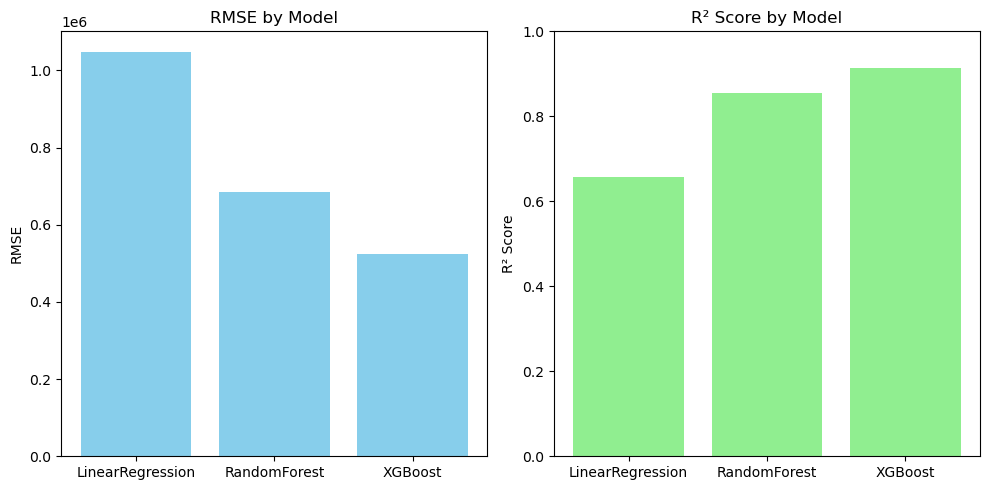

In [1]:
import random
import pandas as pd
from datetime import datetime
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt

# ===========================
# DATA GENERATION FUNCTIONS
# ===========================

current_year = 2025

employment_statuses = ['employed', 'unemployed']
categories = ['daily', 'weekly', 'monthly']
repayment_ratings = ['Excellent', 'Better', 'Good', 'Bad', 'Poor']
ages = [5, 10, 13, 15, 18, 20, 25, 30, 35, 40, 50, 55, 60, 65, 70, 75]
guardian_options = [True, False]
saving_status_options = ['Excellent', 'Better', 'Good', 'Bad', 'Poor']
saving_times_map = {'daily': [1], 'weekly': [1, 2, 3, 4, 5], 'monthly': [1, 5, 10, 15, 20, 25]}

def get_total_saving_times(category, times):
    return {
        'daily': times * 365,
        'weekly': times * 52,
        'monthly': times * 12
    }[category]

def get_age_factor(age):
    if age <= 10: return 0.10
    elif age <= 15: return 0.30
    elif age <= 18: return 0.40
    elif age <= 50: return 1.00
    elif age <= 70: return 0.70
    else: return 0.0

def get_repayment_factor(rating):
    return {'Excellent': 1.0, 'Better': 0.8, 'Good': 0.6, 'Bad': 0.4, 'Poor': 0.2}[rating]

def calculate_loan_features(row):
    avg_saving = row['TotalCurrentSaving'] / max(row['UserSavingsMade'], 1)
    saving_ratio = row['UserSavingsMade'] / max(row['CompletedSavingCycles'], 1)
    remaining_cycles = row['TotalSavingCycles'] - row['CompletedSavingCycles']
    expected_additional_saves = remaining_cycles * saving_ratio
    expected_contribution_cycles = row['UserSavingsMade'] + expected_additional_saves
    expected_total_saving = avg_saving * expected_contribution_cycles

    # Assign rating factor
    if saving_ratio == 1.0: rating_factor, user_rating = 1.0, "Excellent"
    elif saving_ratio >= 0.8: rating_factor, user_rating = 0.8, "Better"
    elif saving_ratio >= 0.6: rating_factor, user_rating = 0.6, "Good"
    elif saving_ratio >= 0.4: rating_factor, user_rating = 0.4, "Bad"
    else: rating_factor, user_rating = 0.2, "Poor"

    expected_loan = expected_total_saving * rating_factor

    remain_times_rating = min(remaining_cycles / max(row['CompletedSavingCycles'], 1), 1.0)
    repayment_factor = get_repayment_factor(row['RecentLoanPaymentStatus'])
    membership_duration = current_year - row['UserJoinedYear']
    years_of_ikimina = current_year - row['IkiminaCreatedYear']
    membership_duration_rating = min(membership_duration / max(years_of_ikimina, 1), 1.0)

    employment_factor = 1.0 if row['EmploymentStatus'] == 'employed' else 0.0
    guardian_factor = 0.5 if row['HasGuardian'] else 1.0
    age_factor = get_age_factor(row['Age'])

    total_score = (
        remain_times_rating * 0.40 +
        repayment_factor * 0.30 +
        membership_duration_rating * 0.15 +
        employment_factor * 0.05 +
        guardian_factor * 0.05 +
        age_factor * 0.05
    )

    boost = expected_loan * 0.50 * total_score
    allowed_loan = expected_loan + boost
    allowed_loan = min(allowed_loan, row['TotalCurrentSaving'] * 2)

    return {
        'SavingStatus': user_rating,
        'SavingRatingFactor': rating_factor,
        'SavingRatio': round(saving_ratio, 2),
        'ExpectedLoan': round(expected_loan, 2),
        'BoostAmount': round(boost, 2),
        'AllowedLoan': round(allowed_loan, 2)
    }

def generate_dataset():
    data = []
    member_id = 1
    for cat in categories:
        for times in saving_times_map[cat]:
            total_cycles = get_total_saving_times(cat, times)
            for repay in repayment_ratings:
                for age in ages:
                    for guardian in guardian_options:
                        for employment in employment_statuses:
                            total_saving = random.randint(1000, 5_000_000)
                            completed = int(total_cycles * random.uniform(0.5, 1.0))
                            made = int(completed * random.uniform(0.3, 1.0))
                            joined = random.randint(2016, 2024)
                            created = random.randint(2015, joined)

                            row = {
                                'MemberID': member_id,
                                'SavingFrequency': cat,
                                'SavingTimesPerPeriod': times,
                                'TotalSavingCycles': total_cycles,
                                'CompletedSavingCycles': completed,
                                'UserSavingsMade': made,
                                'TotalCurrentSaving': total_saving,
                                'IkiminaCreatedYear': created,
                                'UserJoinedYear': joined,
                                'EmploymentStatus': employment,
                                'HasGuardian': guardian,
                                'Age': age,
                                'RecentLoanPaymentStatus': repay
                            }

                            features = calculate_loan_features(row)
                            row.update(features)
                            data.append(row)
                            member_id += 1
    return pd.DataFrame(data)

# =====================
# TRAINING PIPELINE
# =====================

# 1. Generate dataset
df = generate_dataset()

# 2. Encode categorical columns
categorical_cols = ['SavingFrequency', 'RecentLoanPaymentStatus', 'SavingStatus', 'EmploymentStatus']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col]) + 1
    label_encoders[col] = le

# 3. Define features and target
features = [
    'SavingFrequency', 'SavingTimesPerPeriod', 'TotalCurrentSaving',
    'CompletedSavingCycles', 'UserSavingsMade', 'EmploymentStatus',
    'HasGuardian', 'RecentLoanPaymentStatus', 'UserJoinedYear',
    'IkiminaCreatedYear', 'Age'
]
target = 'AllowedLoan'

X = df[features]
y = df[target]

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Train models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

results = {}

# 6. Fit and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2
    }

    print(f"\n📊 {name} Evaluation:")
    print(f"✅ MAE:  {mae:.2f}")
    print(f"✅ MSE:  {mse:.2f}")
    print(f"✅ RMSE: {rmse:.2f}")
    print(f"✅ R²:   {r2:.4f}")

# =====================
# Visualize RMSE and R²
# =====================
plt.figure(figsize=(10,5))

# RMSE plot
plt.subplot(1,2,1)
plt.bar(results.keys(), [v['RMSE'] for v in results.values()], color='skyblue')
plt.title("RMSE by Model")
plt.ylabel("RMSE")

# R2 plot
plt.subplot(1,2,2)
plt.bar(results.keys(), [v['R2'] for v in results.values()], color='lightgreen')
plt.title("R² Score by Model")
plt.ylabel("R² Score")
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


In [2]:
import pickle

# Identify best model by R²
best_model_name = max(results, key=lambda x: results[x]["R2"])
best_model = models[best_model_name]

# Save the best model
model_filename = f"{best_model_name}_IMS_Loan_Model.pkl"
with open(model_filename, 'wb') as f:
    pickle.dump(best_model, f)

print(f"\n✅ Best model saved: {model_filename}")



✅ Best model saved: XGBoost_IMS_Loan_Model.pkl


In [4]:
import gradio as gr
import pandas as pd
import pickle

# === Load the trained model ===
model = pickle.load(open("XGBoost_IMS_Loan_Model.pkl", "rb"))  # Change if your best was XGBoost or Linear

# === Label Encoders (must match training order) ===
saving_freq_map = {'daily': 1, 'weekly': 2, 'monthly': 3}
repayment_status_map = {'Excellent': 1, 'Better': 2, 'Good': 3, 'Bad': 4, 'Poor': 5}
employment_status_map = {'employed': 1, 'unemployed': 2}

# === Prediction Function ===
def predict_allowed_loan(saving_freq, times_per_period, total_saving,
                         completed_cycles, savings_made, employment_status,
                         has_guardian, repayment_status, user_year, group_year, age):

    data = {
        'SavingFrequency': saving_freq_map[saving_freq],
        'SavingTimesPerPeriod': times_per_period,
        'TotalCurrentSaving': total_saving,
        'CompletedSavingCycles': completed_cycles,
        'UserSavingsMade': savings_made,
        'EmploymentStatus': employment_status_map[employment_status],
        'HasGuardian': 1 if has_guardian else 0,
        'RecentLoanPaymentStatus': repayment_status_map[repayment_status],
        'UserJoinedYear': user_year,
        'IkiminaCreatedYear': group_year,
        'Age': age
    }

    df = pd.DataFrame([data])
    prediction = model.predict(df)[0]

    return f"{prediction:,.2f} units"

# === Gradio UI ===
iface = gr.Interface(
    fn=predict_allowed_loan,
    inputs=[
        gr.Radio(['daily', 'weekly', 'monthly'], label="Saving Frequency"),
        gr.Number(label="Saving Times Per Period"),
        gr.Number(label="Total Current Saving"),
        gr.Number(label="Completed Saving Cycles"),
        gr.Number(label="User Savings Made"),
        gr.Radio(['employed', 'unemployed'], label="Employment Status"),
        gr.Checkbox(label="Has Guardian"),
        gr.Radio(['Excellent', 'Better', 'Good', 'Bad', 'Poor'], label="Recent Loan Payment Status"),
        gr.Number(label="User Joined Year (e.g. 2020)"),
        gr.Number(label="Ikimina Created Year (e.g. 2015)"),
        gr.Number(label="User Age")
    ],
    outputs=gr.Textbox(label="Predicted Allowed Loan"),
    title="💰 IMS Loan Allowed Prediction",
    description="Enter member savings and profile data to predict their allowed loan amount."
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "C:\Users\user\anaconda3\Lib\site-packages\gradio\queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\Lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\Lib\site-packages\gradio\blocks.py", line 2042, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\Lib\site-packages\gradio\blocks.py", line 1589, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\Lib\site-packages\anyio\to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
      